## Importowanie bibliotek

In [113]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.src.layers import Dropout
from keras.src.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

## Załadowanie zmiennych

Zmienne zostają załadowane z pliku wygenerowanego z notebooka DataAnalysis.ipynb przy pomocy biblioteki pickle, służącej do serializacji oraz deserializacji danych.

In [114]:
with open('data_dump/dataAnalysisVars.pkl', 'rb') as f:
    df = pickle.load(f)

    df_0 = pickle.load(f)
    df_mean = pickle.load(f)
    df_interpolate = pickle.load(f)

    normalized_std_0 = pickle.load(f)
    scaler_std_0 = pickle.load(f)

    normalized_std_mean = pickle.load(f)
    scaler_std_mean = pickle.load(f)

    normalized_std_interpolate = pickle.load(f)
    scaler_std_interpolate = pickle.load(f)

    normalized_minmax_0 = pickle.load(f)
    scaler_minmax_0 = pickle.load(f)

    normalized_minmax_mean = pickle.load(f)
    scaler_minmax_mean = pickle.load(f)

    normalized_minmax_interpolate = pickle.load(f)
    scaler_minmax_interpolate = pickle.load(f)

## Funkcje do podziału zbioru danych

Utworzono dwie funkcje do tworzenia podziału danych. Split_df_train_test odpowiada za podział danych na dwa zbiory: testowy i treningowy. Natomiast druga funkcja dodaje jeszcze trzeci zbiór - walidacyjny, jest on konieczny do użycia modelu MLP.
Dane są dzielone z równomiernym podziałem klas, aby zapobiec sytuacji, w której podczas podziału danych, przydzielono do zbioru treningowego tylko jedną klasę danych. 

In [115]:
def split_df_train_test(data, test_size, seed):
    np.random.seed(seed)

    unique_labels = data['Potability'].unique()
    label_counts = data['Potability'].value_counts()

    test_indices = []

    for label in unique_labels:
        num_label_samples = label_counts[label]
        num_test_samples = int(test_size * num_label_samples)
        label_indices = data.index[data['Potability'] == label].tolist()
        label_test_indices = np.random.choice(label_indices, size=num_test_samples, replace=False)
        test_indices.extend(label_test_indices)

    train_indices = np.setdiff1d(data.index, test_indices)

    train_set = data.loc[train_indices]
    test_set = data.loc[test_indices]

    return train_set, test_set

def split_df_train_val_test(data, val_size, test_size, seed):
    np.random.seed(seed)

    unique_labels = data['Potability'].unique()
    label_counts = data['Potability'].value_counts()

    val_size = int(val_size * len(data))
    test_size = int(test_size * len(data))

    val_indices = []
    test_indices = []

    for label in unique_labels:
        num_label_samples = label_counts[label]

        num_val_samples = int(val_size * (num_label_samples / len(data)))
        num_test_samples = int(test_size * (num_label_samples / len(data)))

        label_indices = data.index[data['Potability'] == label].tolist()

        label_val_indices = np.random.choice(label_indices, size=num_val_samples, replace=False)
        val_indices.extend(label_val_indices)

        remaining_indices = np.setdiff1d(label_indices, label_val_indices)
        label_test_indices = np.random.choice(remaining_indices, size=num_test_samples, replace=False)
        test_indices.extend(label_test_indices)

    train_indices = np.setdiff1d(data.index, np.concatenate((val_indices, test_indices)))

    train_set = data.loc[train_indices]
    val_set = data.loc[val_indices]
    test_set = data.loc[test_indices]

    return train_set, val_set, test_set

def calculate_f1_score(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    
    precision_positives = true_positives / (true_positives + false_positives)
    recall_positives = true_positives / (true_positives + false_negatives)
    f1_score_positives = 2 * (precision_positives * recall_positives) / (precision_positives + recall_positives)

    precision_negatives = true_negatives / (true_negatives + false_negatives)
    recall_negatives = true_negatives / (true_negatives + false_positives)
    f1_score_negatives = 2 * (precision_negatives * recall_negatives) / (precision_negatives + recall_negatives)

    f1_score = (f1_score_positives + f1_score_negatives) /2
    return f1_score

# Modele

W celu osiągnięcia jak najlepszej skuteczności postanowiono spróbować klasyfikatorów:
 - SVM
 - Random Forest
 - Gradient Boosting
 - XGBoost
 - MLP Keras
 - Voting

Do każdego klasyfikatora utworzono klasę wrappera, która posiada niezbędne funkcje do inicjalizacji, trenowania i ewaluacji danych. 
Dodatkowo użyto biblioteki RandomizedSearchCV do optymalizacji parametrów klasyfikatora. Wydłuża to czas trenowania modelu, ale poprawia skuteczność modelu. 

## SVM - Scikit-Learn

In [116]:
class SVMClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self.test_pred = None
        self._create_model()

    def _create_model(self):
        self.model = SVC(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'C': [0.1, 1, 5, 10],
                'probability': [True, False],
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=8, cv=5, random_state=645, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        self.test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, self.test_pred)
        test_f1 = calculate_f1_score(self.test_label, self.test_pred)
        print('-' * 18 + ' SVM ' + '-' * 18)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('Test F1:', test_f1)
        print('-' * 41)
        return test_acc, test_f1

    def get_confussion_matrix(self):
        confusion_matrix = metrics.confusion_matrix(self.test_label, self.test_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        return cm_display


## Random Forest - Scikit-Learn

In [117]:
class RandomForestClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self.test_pred = None
        self._create_model()

    def _create_model(self):
        self.model = RandomForestClassifier(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 150],
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=12, cv=5, random_state=42, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        self.test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, self.test_pred)
        test_f1 = calculate_f1_score(self.test_label, self.test_pred)
        print('-' * 13 + ' Random Forest ' + '-' * 13)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('Test F1:', test_f1)
        print('-' * 41)
        return test_acc, test_f1
    
    def get_confussion_matrix(self):
        confusion_matrix = metrics.confusion_matrix(self.test_label, self.test_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        return cm_display


### Gradient Boosting

In [118]:
class GBClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self.test_pred = None
        self._create_model()

    def _create_model(self):
        self.model = GradientBoostingClassifier(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 150]
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=3, cv=5, random_state=645, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        self.test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, self.test_pred)
        test_f1 = calculate_f1_score(self.test_label, self.test_pred)
        print('-' * 11 + ' Gradient Boosting ' + '-' * 11)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('Test F1:', test_f1)
        print('-' * 41)
        return test_acc, test_f1
    
    def get_confussion_matrix(self):
        confusion_matrix = metrics.confusion_matrix(self.test_label, self.test_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        return cm_display

### XGBoost

In [119]:
class XGBClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self.test_pred = None
        self._create_model()

    def _create_model(self):
        self.model = XGBClassifier(random_state=42, tree_method = "hist", device = "cuda")

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100],
                'max_depth': [3, 5, 10],
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=6, cv=5, random_state=678, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        self.test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, self.test_pred)
        test_f1 = calculate_f1_score(self.test_label, self.test_pred)
        print('-' * 16 + ' XGBoost ' + '-' * 16)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('Test F1:', test_f1)
        print('-' * 41)
        return test_acc, test_f1
    
    def get_confussion_matrix(self):
        confusion_matrix = metrics.confusion_matrix(self.test_label, self.test_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        return cm_display


## MLP - Keras

In [120]:
class MLPClassifierWrapper:

    def __init__(self, train_set, val_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.val_set = val_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.val_label = val_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = Sequential()

        self.model.add(Input(shape=(9,)))
        self.model.add(Dense(40, activation='leaky_relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation='leaky_relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(20, activation='leaky_relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self):
        self.history = self.model.fit(self.train_set, self.train_label, epochs=150, batch_size=64, validation_data=(self.val_set, self.val_label))

    def evaluate_model(self):
        test_loss, test_acc = self.model.evaluate(self.test_set, self.test_label)
        print('-' * 18 + ' MLP ' + '-' * 18)
        print('Test accuracy:', test_acc)
        print('Test loss:', test_loss)
        print('-' * 41)
        return test_acc

    def plot_results(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Voting classifier 

In [121]:
class VotingClassifierWrapper:
    def __init__(self, train_set, test_set, modelSVM, modelRF, modelGB, modelXGB):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.modelSVM = modelSVM
        self.modelRF = modelRF
        self.modelGB = modelGB
        self.modelXGB = modelXGB
        self.model = None
        self.history = None
        self.test_pred = None
        self._create_model()

    def _create_model(self):
        clf_labels = ['SVM', 'RandomForest', 'GradientBoosting', 'XGBoost']
        self.model = VotingClassifier(estimators=[
            (clf_labels[0], self.modelSVM),
            (clf_labels[1], self.modelRF),
            (clf_labels[2], self.modelGB),
            (clf_labels[3], self.modelXGB),
        ])

    def train_model(self):
        self.model = self.model.fit(self.train_set, self.train_label)

    def evaluate_model(self):
        self.test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, self.test_pred)
        test_f1 = calculate_f1_score(self.test_label, self.test_pred)
        print('-' * 18 + ' VotingClassifier ' + '-' * 18)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('Test F1:', test_f1)
        print('-' * 41)
        return test_acc, test_f1
    
    def get_confussion_matrix(self):
        confusion_matrix = metrics.confusion_matrix(self.test_label, self.test_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        return cm_display


## Trenowanie modeli

### Split danych

Podzielenie danych przy pomocy funkcji "split_df_train_test" oraz "split_df_train_val_test"

In [122]:
# Std zeros
train_std_0, test_std_0 = split_df_train_test(normalized_std_0, 0.2, 123)
train_std_mlp_0, val_std_mlp_0, test_std_mlp_0 = split_df_train_val_test(normalized_minmax_0, 0.1, 0.1, 111)

# Std mean
train_std_mean, test_std_mean = split_df_train_test(normalized_std_mean, 0.2, 123)
train_std_mlp_mean, val_std_mlp_mean, test_std_mlp_mean = split_df_train_val_test(normalized_std_mean, 0.1, 0.1, 111)

# Std interpolate
train_std_interpolate, test_std_interpolate = split_df_train_test(normalized_std_interpolate, 0.2, 123)
train_std_mlp_interpolate, val_std_mlp_interpolate, test_std_mlp_interpolate = split_df_train_val_test(normalized_std_interpolate, 0.1, 0.1, 111)

# Minmax zeros
train_minmax_0, test_minmax_0 = split_df_train_test(normalized_minmax_0, 0.2, 123)
train_minmax_mlp_0, val_minmax_mlp_0, test_minmax_mlp_0 = split_df_train_val_test(normalized_minmax_0, 0.1, 0.1, 111)

# Minmax mean
train_minmax_mean, test_minmax_mean = split_df_train_test(normalized_minmax_mean, 0.2, 123)
train_minmax_mlp_mean, val_minmax_mlp_mean, test_minmax_mlp_mean = split_df_train_val_test(normalized_minmax_mean, 0.1, 0.1, 111)

# Minmax interpolate
train_minmax_interpolate, test_minmax_interpolate = split_df_train_test(normalized_minmax_interpolate, 0.2, 123)
train_minmax_mlp_interpolate, val_minmax_mlp_interpolate, test_minmax_mlp_interpolate = split_df_train_val_test(normalized_minmax_interpolate, 0.1, 0.1, 111)

### Podział klas po splicie - test/train

In [123]:
train_class_counts = train_minmax_interpolate['Potability'].value_counts(normalize=True) * 100
test_class_counts = test_minmax_interpolate['Potability'].value_counts(normalize=True) * 100

print("Train set:")
print(train_class_counts)
print("\nTest set:")
print(test_class_counts)

Train set:
Potability
0    60.983982
1    39.016018
Name: proportion, dtype: float64

Test set:
Potability
0    61.009174
1    38.990826
Name: proportion, dtype: float64


### Podział klas po splicie - test/val/train

In [124]:
train_mlp_class_counts = train_minmax_mlp_interpolate['Potability'].value_counts(normalize=True) * 100
val_mlp_class_counts = val_minmax_mlp_interpolate['Potability'].value_counts(normalize=True) * 100
test_mlp_class_counts = test_minmax_mlp_interpolate['Potability'].value_counts(normalize=True) * 100

print("Train MLP set:")
print(train_mlp_class_counts)
print("\nValidation MLP set:")
print(val_mlp_class_counts)
print("\nTest MLP set:")
print(test_mlp_class_counts)

Train MLP set:
Potability
0    60.97561
1    39.02439
Name: proportion, dtype: float64

Validation MLP set:
Potability
0    61.042945
1    38.957055
Name: proportion, dtype: float64

Test MLP set:
Potability
0    61.042945
1    38.957055
Name: proportion, dtype: float64


### Trenowanie SVM

In [125]:
# Std zeros
modelSVM_std_0 = SVMClassifierWrapper(train_std_0, test_std_0)
modelSVM_std_0.train_model()
accuracy_SVM_std_0, f1_SVM_std_0 = modelSVM_std_0.evaluate_model()

# Std mean
modelSVM_std_mean = SVMClassifierWrapper(train_std_mean, test_std_mean)
modelSVM_std_mean.train_model()
accuracy_SVM_std_mean, f1_SVM_std_mean = modelSVM_std_mean.evaluate_model()

# Std interpolate
modelSVM_std_interpolate = SVMClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelSVM_std_interpolate.train_model()
accuracy_SVM_std_interpolate, f1_SVM_std_interpolate = modelSVM_std_interpolate.evaluate_model()

# Minmax zeros
modelSVM_minmax_0 = SVMClassifierWrapper(train_minmax_0, test_minmax_0)
modelSVM_minmax_0.train_model()
accuracy_SVM_minmax_0, f1_SVM_minmax_0 = modelSVM_minmax_0.evaluate_model()

# Minmax mean
modelSVM_minmax_mean = SVMClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelSVM_minmax_mean.train_model()
accuracy_SVM_minmax_mean, f1_SVM_minmax_mean = modelSVM_minmax_mean.evaluate_model()

# Minmax interpolate
modelSVM_minmax_interpolate = SVMClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelSVM_minmax_interpolate.train_model()
accuracy_SVM_minmax_interpolate, f1_SVM_minmax_interpolate = modelSVM_minmax_interpolate.evaluate_model()

------------------ SVM ------------------
C: 5
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: True
tol: 0.001
verbose: False
-----------------------------------------
Test accuracy: 0.6207951070336392
Test F1: 0.5496117917559896
-----------------------------------------
------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: True
tol: 0.001
verbose: False
-----------------------------------------
Test accuracy: 0.672782874617737
Test F1: 0.5840980410802586
-----------------------------------------
------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_

### Trenowanie Random Forest

In [126]:
# Std zeros
modelRF_std_0 = RandomForestClassifierWrapper(train_std_0, test_std_0)
modelRF_std_0.train_model()
accuracy_RF_std_0, f1_RF_std_0 = modelRF_std_0.evaluate_model()

# Std mean
modelRF_std_mean = RandomForestClassifierWrapper(train_std_mean, test_std_mean)
modelRF_std_mean.train_model()
accuracy_RF_std_mean, f1_RF_std_mean = modelRF_std_mean.evaluate_model()

# Std interpolate
modelRF_std_interpolate = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelRF_std_interpolate.train_model()
accuracy_RF_std_interpolate, f1_RF_std_interpolate = modelRF_std_interpolate.evaluate_model()

# Minmax zeros
modelRF_minmax_0 = RandomForestClassifierWrapper(train_minmax_0, test_minmax_0)
modelRF_minmax_0.train_model()
accuracy_RF_minmax_0, f1_RF_minmax_0 = modelRF_minmax_0.evaluate_model()

# Minmax mean
modelRF_minmax_mean = RandomForestClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelRF_minmax_mean.train_model()
accuracy_RF_minmax_mean, f1_RF_minmax_mean = modelRF_minmax_mean.evaluate_model()

# Minmax interpolate
modelRF_minmax_interpolate = RandomForestClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelRF_minmax_interpolate.train_model()
accuracy_RF_minmax_interpolate, f1_RF_minmax_interpolate = modelRF_minmax_interpolate.evaluate_model()

------------- Random Forest -------------
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6406727828746177
Test F1: 0.5713532674935224
-----------------------------------------
------------- Random Forest -------------
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 150
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6697247706422018
Test F1: 0.6077263992713459
--

### Trenowanie Gradient Boosting

In [127]:
# Std zeros
modelGB_std_0 = GBClassifierWrapper(train_std_0, test_std_0)
modelGB_std_0.train_model()
accuracy_GB_std_0, f1_GB_std_0 = modelGB_std_0.evaluate_model()

# Std mean
modelGB_std_mean = GBClassifierWrapper(train_std_mean, test_std_mean)
modelGB_std_mean.train_model()
accuracy_GB_std_mean, f1_GB_std_mean = modelGB_std_mean.evaluate_model()

# Std interpolate
modelGB_std_interpolate = GBClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelGB_std_interpolate.train_model()
accuracy_GB_std_interpolate, f1_GB_std_interpolate = modelGB_std_interpolate.evaluate_model()

# Minmax zeros
modelGB_minmax_0 = GBClassifierWrapper(train_minmax_0, test_minmax_0)
modelGB_minmax_0.train_model()
accuracy_GB_minmax_0, f1_GB_minmax_0 = modelGB_minmax_0.evaluate_model()

# Minmax mean
modelGB_minmax_mean = GBClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelGB_minmax_mean.train_model()
accuracy_GB_minmax_mean, f1_GB_minmax_mean = modelGB_minmax_mean.evaluate_model()

# Minmax interpolate
modelGB_minmax_interpolate = GBClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelGB_minmax_interpolate.train_model()
accuracy_GB_minmax_interpolate, f1_GB_minmax_interpolate = modelGB_minmax_interpolate.evaluate_model()

----------- Gradient Boosting -----------
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: log_loss
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 50
n_iter_no_change: None
random_state: 42
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6207951070336392
Test F1: 0.4954206072672971
-----------------------------------------
----------- Gradient Boosting -----------
ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: log_loss
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 50
n_iter_no_change: None
random_state: 42
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False
------------------------

### Trenowanie XGBoost

In [128]:
# Std zeros
modelXGB_std_0 = XGBClassifierWrapper(train_std_0, test_std_0)
modelXGB_std_0.train_model()
accuracy_XGB_std_0, f1_XGB_std_0 = modelXGB_std_0.evaluate_model()

# Std mean
modelXGB_std_mean = XGBClassifierWrapper(train_std_mean, test_std_mean)
modelXGB_std_mean.train_model()
accuracy_XGB_std_mean, f1_XGB_std_mean = modelXGB_std_mean.evaluate_model()

# Std interpolate
modelXGB_std_interpolate = XGBClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelXGB_std_interpolate.train_model()
accuracy_XGB_std_interpolate, f1_XGB_std_interpolate = modelXGB_std_interpolate.evaluate_model()

# Minmax zeros
modelXGB_minmax_0 = XGBClassifierWrapper(train_minmax_0, test_minmax_0)
modelXGB_minmax_0.train_model()
accuracy_XGB_minmax_0, f1_XGB_minmax_0 = modelXGB_minmax_0.evaluate_model()

# Minmax mean
modelXGB_minmax_mean = XGBClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelXGB_minmax_mean.train_model()
accuracy_XGB_minmax_mean, f1_XGB_minmax_mean = modelXGB_minmax_mean.evaluate_model()

# Minmax interpolate
modelXGB_minmax_interpolate = XGBClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelXGB_minmax_interpolate.train_model()
accuracy_XGB_minmax_interpolate, f1_XGB_minmax_interpolate = modelXGB_minmax_interpolate.evaluate_model()

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


---------------- XGBoost ----------------
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 3
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 50
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: None
-----------------------------------------
Test accuracy: 0.6207951070336392
Test F1: 0.5469750293279705
-----------------------------------------


c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


---------------- XGBoost ----------------
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 3
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 100
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: None
-----------------------------------------
Test accuracy: 0.6529051987767585
Test F1: 0.5994063600426341
-----------------------------------------


c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


---------------- XGBoost ----------------
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 3
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 100
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: None
-----------------------------------------
Test accuracy: 0.6513761467889908
Test F1: 0.6077981651376146
-----------------------------------------


c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:00:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


---------------- XGBoost ----------------
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 3
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 50
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: None
-----------------------------------------
Test accuracy: 0.6207951070336392
Test F1: 0.5469750293279705
-----------------------------------------


c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:00:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


---------------- XGBoost ----------------
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 3
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 100
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: None
-----------------------------------------
Test accuracy: 0.6529051987767585
Test F1: 0.5994063600426341
-----------------------------------------
---------------- XGBoost -------------

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:00:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


### Trenowanie MLP

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5906 - loss: 0.6848 - val_accuracy: 0.6012 - val_loss: 0.6779
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5865 - loss: 0.6828 - val_accuracy: 0.6074 - val_loss: 0.6763
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6091 - loss: 0.6716 - val_accuracy: 0.6074 - val_loss: 0.6750
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6087 - loss: 0.6753 - val_accuracy: 0.6074 - val_loss: 0.6742
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6043 - loss: 0.6690 - val_accuracy: 0.6074 - val_loss: 0.6735
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6217 - loss: 0.6664 - val_accuracy: 0.6074 - val_loss: 0.6726
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5997 - loss: 0.6698 - val_accuracy: 0.6074 - val_loss: 0.6726
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5910 - loss: 0.6779 - val_accuracy: 0.6104 - v

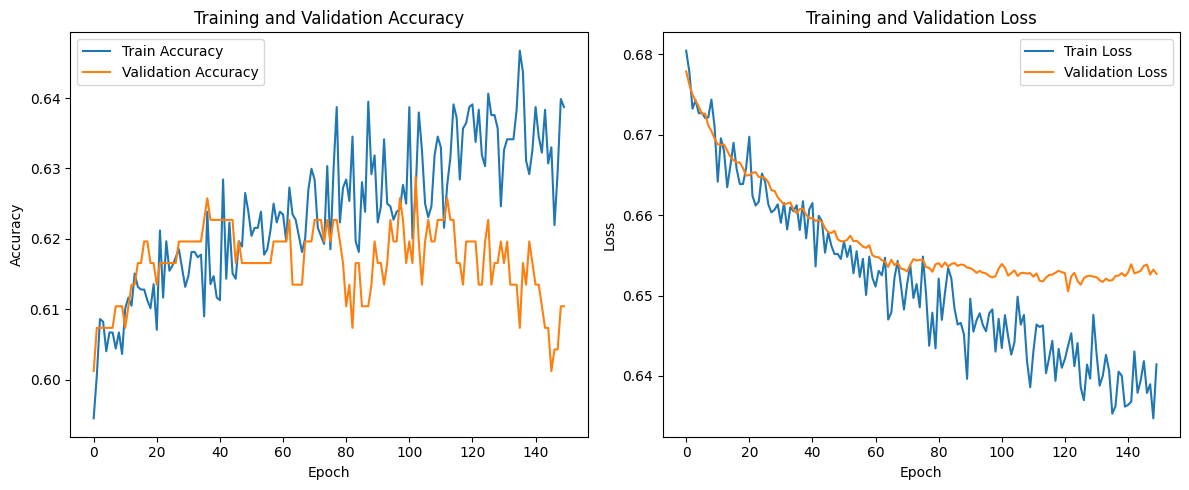

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5560 - loss: 0.6872 - val_accuracy: 0.5798 - val_loss: 0.6908
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5603 - loss: 0.6920 - val_accuracy: 0.6074 - val_loss: 0.6857
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5985 - loss: 0.6668 - val_accuracy: 0.6135 - val_loss: 0.6823
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5956 - loss: 0.6768 - val_accuracy: 0.6227 - val_loss: 0.6792
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 0.6655 - val_accuracy: 0.6258 - val_loss: 0.6759
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6029 - loss: 0.6768 - val_accuracy: 0.6258 - val_loss: 0.6737
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6207 - loss: 0.6620 - val_accuracy: 0.6288 - val_loss: 0.6714
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6090 - loss: 0.6665 - val_accuracy: 0.6288 - v

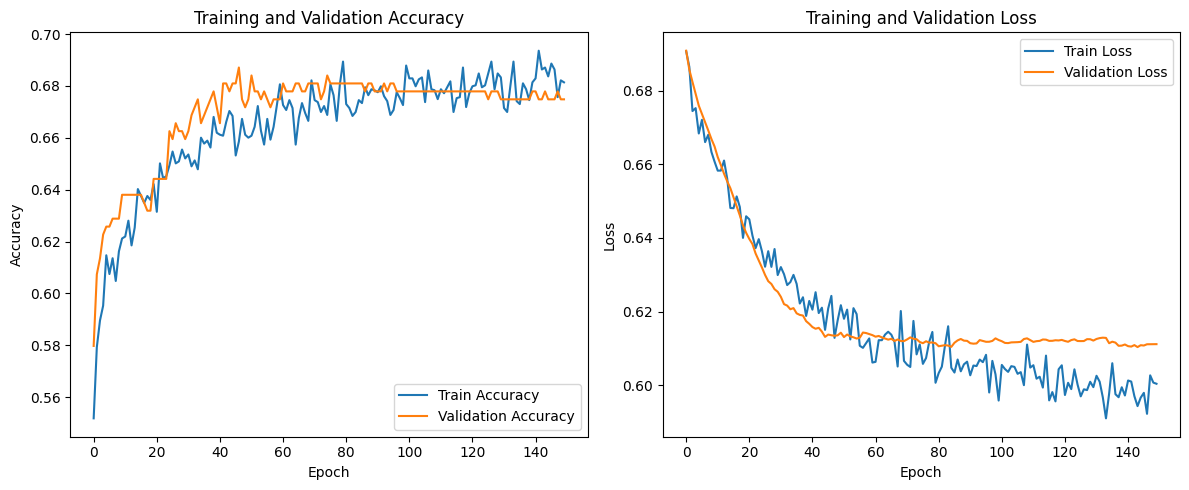

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5793 - loss: 0.6969 - val_accuracy: 0.6104 - val_loss: 0.6844
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5876 - loss: 0.6905 - val_accuracy: 0.6135 - val_loss: 0.6818
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6106 - loss: 0.6731 - val_accuracy: 0.6104 - val_loss: 0.6794
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5970 - loss: 0.6796 - val_accuracy: 0.6074 - val_loss: 0.6779
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5840 - loss: 0.6856 - val_accuracy: 0.6135 - val_loss: 0.6769
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6106 - loss: 0.6742 - val_accuracy: 0.6166 - val_loss: 0.6751
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6087 - loss: 0.6756 - val_accuracy: 0.6135 - val_loss: 0.6742
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5957 - loss: 0.6772 - val_accuracy: 0.6166 - v

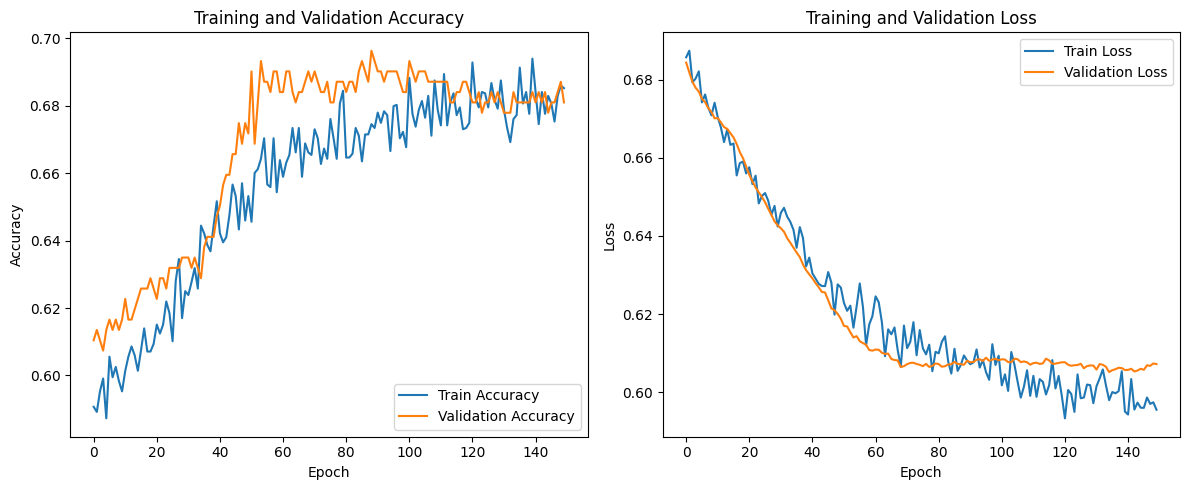

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4510 - loss: 0.7528 - val_accuracy: 0.5552 - val_loss: 0.6928
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4894 - loss: 0.7131 - val_accuracy: 0.6227 - val_loss: 0.6798
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5605 - loss: 0.6919 - val_accuracy: 0.6135 - val_loss: 0.6764
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 0.6947 - val_accuracy: 0.6104 - val_loss: 0.6753
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5652 - loss: 0.6873 - val_accuracy: 0.6104 - val_loss: 0.6748
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5840 - loss: 0.6861 - val_accuracy: 0.6104 - val_loss: 0.6746
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 0.6668 - val_accuracy: 0.6104 - val_loss: 0.6746
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6029 - loss: 0.6733 - val_accuracy: 0.6104 - v

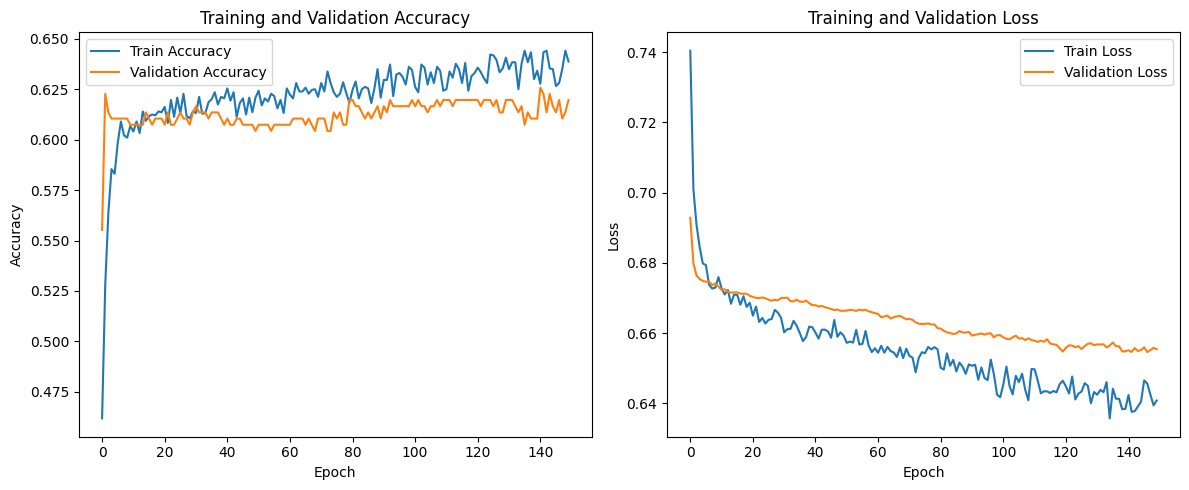

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5333 - loss: 0.7094 - val_accuracy: 0.6104 - val_loss: 0.6819
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5779 - loss: 0.6871 - val_accuracy: 0.6104 - val_loss: 0.6781
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5805 - loss: 0.6753 - val_accuracy: 0.6104 - val_loss: 0.6754
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6061 - loss: 0.6738 - val_accuracy: 0.6104 - val_loss: 0.6745
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5758 - loss: 0.6844 - val_accuracy: 0.6104 - val_loss: 0.6735
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5904 - loss: 0.6782 - val_accuracy: 0.6104 - val_loss: 0.6729
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5924 - loss: 0.6726 - val_accuracy: 0.6104 - val_loss: 0.6721
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5839 - loss: 0.6818 - val_accuracy: 0.6135 - v

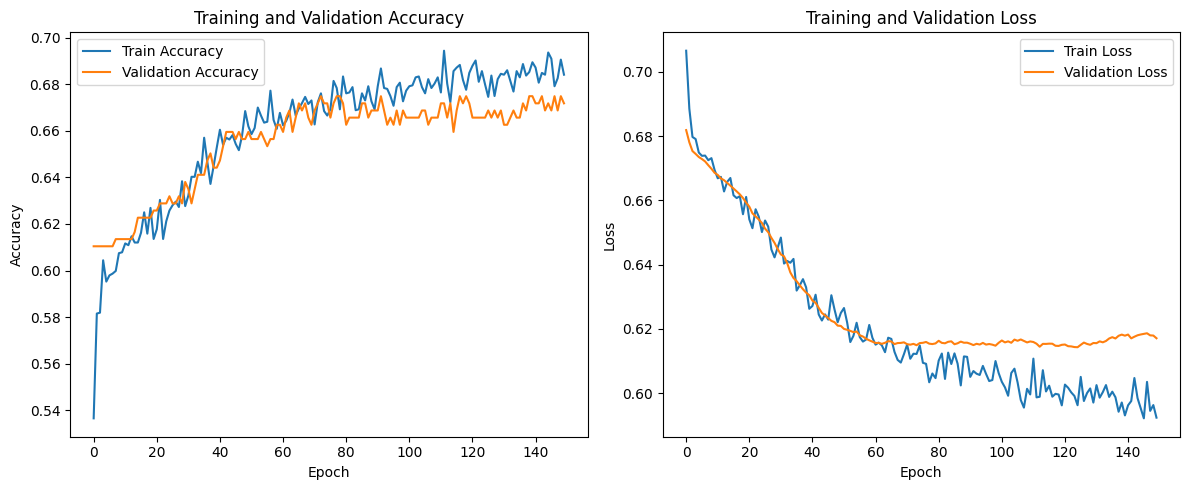

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5464 - loss: 0.7147 - val_accuracy: 0.5644 - val_loss: 0.6856
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5614 - loss: 0.7011 - val_accuracy: 0.5982 - val_loss: 0.6810
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5846 - loss: 0.6850 - val_accuracy: 0.6043 - val_loss: 0.6775
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5870 - loss: 0.6849 - val_accuracy: 0.6135 - val_loss: 0.6761
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5783 - loss: 0.6836 - val_accuracy: 0.6104 - val_loss: 0.6743
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5904 - loss: 0.6786 - val_accuracy: 0.6166 - val_loss: 0.6717
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5950 - loss: 0.6761 - val_accuracy: 0.6135 - val_loss: 0.6707
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5943 - loss: 0.6763 - val_accuracy: 0.6104 - v

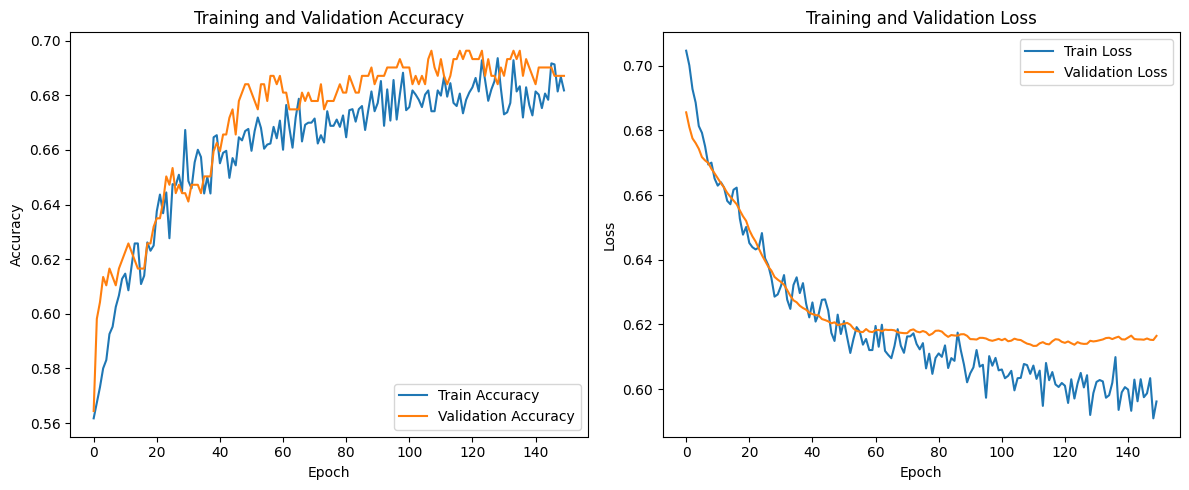

In [129]:
# Std zeros
modelMLP_std_0 = MLPClassifierWrapper(train_std_mlp_0, val_std_mlp_0, test_std_mlp_0)
modelMLP_std_0.train_model()
accuracy_MLP_std_0 = modelMLP_std_0.evaluate_model()
modelMLP_std_0.plot_results()

# Std mean
modelMLP_std_mean = MLPClassifierWrapper(train_std_mlp_mean, val_std_mlp_mean, test_std_mlp_mean)
modelMLP_std_mean.train_model()
accuracy_MLP_std_mean = modelMLP_std_mean.evaluate_model()
modelMLP_std_mean.plot_results()

# Std interpolate
modelMLP_std_interpolate = MLPClassifierWrapper(train_std_mlp_interpolate, val_std_mlp_interpolate, test_std_mlp_interpolate)
modelMLP_std_interpolate.train_model()
accuracy_MLP_std_interpolate = modelMLP_std_interpolate.evaluate_model()
modelMLP_std_interpolate.plot_results()

# Minmax zeros
modelMLP_minmax_0 = MLPClassifierWrapper(train_minmax_mlp_0, val_minmax_mlp_0, test_minmax_mlp_0)
modelMLP_minmax_0.train_model()
accuracy_MLP_minmax_0 = modelMLP_minmax_0.evaluate_model()
modelMLP_minmax_0.plot_results()

# Minmax mean
modelMLP_minmax_mean = MLPClassifierWrapper(train_minmax_mlp_mean, val_minmax_mlp_mean, test_minmax_mlp_mean)
modelMLP_minmax_mean.train_model()
accuracy_MLP_minmax_mean = modelMLP_minmax_mean.evaluate_model()
modelMLP_minmax_mean.plot_results()

# Minmax interpolate
modelMLP_minmax_interpolate = MLPClassifierWrapper(train_minmax_mlp_interpolate, val_minmax_mlp_interpolate, test_minmax_mlp_interpolate)
modelMLP_minmax_interpolate.train_model()
accuracy_MLP_minmax_interpolate = modelMLP_minmax_interpolate.evaluate_model()
modelMLP_minmax_interpolate.plot_results()

## Trenowanie VotingClassifier

Klasyfikator głosujący zbiera klasyfikatory i na podstawie ich predykcji klasyfikuje dane. Jego trenowanie jest na końcu, ponieważ w celu zaoszczędzenia czasu korzysta on z już wytrenowanych klasyfikatorów.

In [130]:
# Std zeros
modelVoting_std_0 = VotingClassifierWrapper(train_std_0, test_std_0, modelSVM_std_0.model, modelRF_std_0.model, modelGB_std_0.model, modelXGB_std_0.model)
modelVoting_std_0.train_model()
accuracy_Voting_std_0, f1_Voting_std_0 = modelVoting_std_0.evaluate_model()

# Std mean
modelVoting_std_mean = VotingClassifierWrapper(train_std_mean, test_std_mean, modelSVM_std_mean.model, modelRF_std_mean.model, modelGB_std_mean.model, modelXGB_std_mean.model)
modelVoting_std_mean.train_model()
accuracy_Voting_std_mean, f1_Voting_std_mean = modelVoting_std_mean.evaluate_model()

# Std interpolate
modelVoting_std_interpolate = VotingClassifierWrapper(train_std_interpolate, test_std_interpolate, modelSVM_std_interpolate.model, modelRF_std_interpolate.model, modelGB_std_interpolate.model, modelXGB_std_interpolate.model)
modelVoting_std_interpolate.train_model()
accuracy_Voting_std_interpolate, f1_Voting_std_interpolate = modelVoting_std_interpolate.evaluate_model()

# Minmax zeros
modelVoting_minmax_0 = VotingClassifierWrapper(train_minmax_0, test_minmax_0, modelSVM_minmax_0.model, modelRF_minmax_0.model, modelGB_minmax_0.model, modelXGB_minmax_0.model)
modelVoting_minmax_0.train_model()
accuracy_Voting_minmax_0, f1_Voting_minmax_0 = modelVoting_minmax_0.evaluate_model()

# Minmax mean
modelVoting_minmax_mean = VotingClassifierWrapper(train_minmax_mean, test_minmax_mean, modelSVM_minmax_mean.model, modelRF_minmax_mean.model, modelGB_minmax_mean.model, modelXGB_minmax_mean.model)
modelVoting_minmax_mean.train_model()
accuracy_Voting_minmax_mean, f1_Voting_minmax_mean = modelVoting_minmax_mean.evaluate_model()

# Minmax interpolate
modelVoting_minmax_interpolate = VotingClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate, modelSVM_minmax_interpolate.model, modelRF_minmax_interpolate.model, modelGB_minmax_interpolate.model, modelXGB_minmax_interpolate.model)
modelVoting_minmax_interpolate.train_model()
accuracy_Voting_minmax_interpolate, f1_Voting_minmax_interpolate = modelVoting_minmax_interpolate.evaluate_model()

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


------------------ VotingClassifier ------------------
estimators: [('SVM', SVC(C=5, probability=True, random_state=42)), ('RandomForest', RandomForestClassifier(random_state=42)), ('GradientBoosting', GradientBoostingClassifier(n_estimators=50, random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tre

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:01:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


------------------ VotingClassifier ------------------
estimators: [('SVM', SVC(C=1, probability=True, random_state=42)), ('RandomForest', RandomForestClassifier(n_estimators=150, random_state=42)), ('GradientBoosting', GradientBoostingClassifier(n_estimators=50, random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
           

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


------------------ VotingClassifier ------------------
estimators: [('SVM', SVC(C=1, probability=True, random_state=42)), ('RandomForest', RandomForestClassifier(criterion='entropy', random_state=42)), ('GradientBoosting', GradientBoostingClassifier(n_estimators=50, random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
        

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


------------------ VotingClassifier ------------------
estimators: [('SVM', SVC(C=5, probability=True, random_state=42)), ('RandomForest', RandomForestClassifier(random_state=42)), ('GradientBoosting', GradientBoostingClassifier(n_estimators=50, random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tre

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:01:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


------------------ VotingClassifier ------------------
estimators: [('SVM', SVC(C=1, probability=True, random_state=42)), ('RandomForest', RandomForestClassifier(n_estimators=150, random_state=42)), ('GradientBoosting', GradientBoostingClassifier(n_estimators=50, random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
           

c:\Users\Krzysztof\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


## Przedstawienie wyników

In [131]:
results_list = [
    ["SVM", accuracy_SVM_std_0, f1_SVM_std_0, "Std", "Zeros"],
    ["SVM", accuracy_SVM_std_mean, f1_SVM_std_mean, "Std", "Mean"],
    ["SVM", accuracy_SVM_std_interpolate, f1_SVM_std_interpolate, "Std", "Interpolate"],
    ["SVM", accuracy_SVM_minmax_0, f1_SVM_minmax_0, "Minmax", "Zeros"],
    ["SVM", accuracy_SVM_minmax_mean, f1_SVM_minmax_mean, "Minmax", "Mean"],
    ["SVM", accuracy_SVM_minmax_interpolate, f1_SVM_minmax_interpolate, "Minmax", "Interpolate"],
    ["Random Forest", accuracy_RF_std_0, f1_RF_std_0, "Std", "Zeros"],
    ["Random Forest", accuracy_RF_std_mean, f1_RF_std_mean, "Std", "Mean"],
    ["Random Forest", accuracy_RF_std_interpolate, f1_RF_std_interpolate, "Std", "Interpolate"],
    ["Random Forest", accuracy_RF_minmax_0, f1_RF_minmax_0, "Minmax", "Zeros"],
    ["Random Forest", accuracy_RF_minmax_mean, f1_RF_minmax_mean, "Minmax", "Mean"],
    ["Random Forest", accuracy_RF_minmax_interpolate, f1_RF_minmax_interpolate, "Minmax", "Interpolate"],
    ["Gradient Boosting", accuracy_GB_std_0, f1_GB_std_0, "Std", "Zeros"],
    ["Gradient Boosting", accuracy_GB_std_mean, f1_GB_std_mean, "Std", "Mean"],
    ["Gradient Boosting", accuracy_GB_std_interpolate, f1_GB_std_interpolate, "Std", "Interpolate"],
    ["Gradient Boosting", accuracy_GB_minmax_0, f1_GB_minmax_0, "Minmax", "Zeros"],
    ["Gradient Boosting", accuracy_GB_minmax_mean, f1_GB_minmax_mean, "Minmax", "Mean"],
    ["Gradient Boosting", accuracy_GB_minmax_interpolate, f1_GB_minmax_interpolate, "Minmax", "Interpolate"],
    ["XGBoost", accuracy_XGB_std_0, f1_XGB_std_0, "Std", "Zeros"],
    ["XGBoost", accuracy_XGB_std_mean, f1_XGB_std_mean, "Std", "Mean"],
    ["XGBoost", accuracy_XGB_std_interpolate, f1_XGB_std_interpolate, "Std", "Interpolate"],
    ["XGBoost", accuracy_XGB_minmax_0, f1_XGB_minmax_0, "Minmax", "Zeros"],
    ["XGBoost", accuracy_XGB_minmax_mean, f1_XGB_minmax_mean, "Minmax", "Mean"],
    ["XGBoost", accuracy_XGB_minmax_interpolate, f1_XGB_minmax_interpolate,"Minmax", "Interpolate"],
    ["MLP", accuracy_MLP_std_0, 0, "Std", "Zeros"],
    ["MLP", accuracy_MLP_std_mean, 0, "Std", "Mean"],
    ["MLP", accuracy_MLP_std_interpolate, 0, "Std", "Interpolate"],
    ["MLP", accuracy_MLP_minmax_0, 0, "Minmax", "Zeros"],
    ["MLP", accuracy_MLP_minmax_mean, 0, "Minmax", "Mean"],
    ["MLP", accuracy_MLP_minmax_interpolate, 0, "Minmax", "Interpolate"],
    ["Voting", accuracy_Voting_std_0, f1_Voting_std_0, "Std", "Zeros"],
    ["Voting", accuracy_Voting_std_mean, f1_Voting_std_mean, "Std", "Mean"],
    ["Voting", accuracy_Voting_std_interpolate, f1_Voting_std_interpolate, "Std", "Interpolate"],
    ["Voting", accuracy_Voting_minmax_0, f1_Voting_minmax_0, "Minmax", "Zeros"],
    ["Voting", accuracy_Voting_minmax_mean, f1_Voting_minmax_mean, "Minmax", "Mean"],
    ["Voting", accuracy_Voting_minmax_interpolate, f1_Voting_minmax_interpolate, "Minmax", "Interpolate"],
]

headers = ["Model", "Accuracy", "F1", "Normalization", "Missing Data"]

results_df = pd.DataFrame(results_list, columns=headers)

results_df

,Model,Accuracy,F1,Normalization,Missing Data
0,SVM,0.620795,0.549612,Std,Zeros
1,SVM,0.672783,0.584098,Std,Mean
2,SVM,0.686544,0.609165,Std,Interpolate
3,SVM,0.620795,0.549612,Minmax,Zeros
4,SVM,0.672783,0.584098,Minmax,Mean
5,SVM,0.686544,0.609165,Minmax,Interpolate
6,Random Forest,0.640673,0.571353,Std,Zeros
7,Random Forest,0.669725,0.607726,Std,Mean
8,Random Forest,0.669725,0.605430,Std,Interpolate
9,Random Forest,0.640673,0.571353,Minmax,Zeros


Po analizie wyników można dojść do wniosków, że:
 - skuteczność każdego z klasyfikatorów jest podobna,
 - w większości przypadków najmniejszą skuteczność miała metoda uzupełniania danych brakujących zerami,
 - skuteczność przy uzupełnianiu średnią i interpolacja jest bardzo podobna,
 - metoda normalizacji nie wpływa na skuteczność,
 - najwyższą skuteczność miał klasyfikator SVM, 
 - najniższą skuteczność miał klasyfikator MLP,
 - skuteczność klasyfikatora Voting jest bardzo zbliżona do siebie, niezależnie od rodzaju wypełaniania brakujących danych  

In [132]:
def showConfussionMatrix(confusion_matrix_list, confusion_matrix_labels_list):
    img, axs = plt.subplots(5, 3, figsize=(15, 25))
    for i, ax in enumerate(axs.flat):
        ax.set_title(confusion_matrix_labels_list[i])
        confusion_matrix_list[i].plot(include_values=True, ax=ax)
    plt.show()

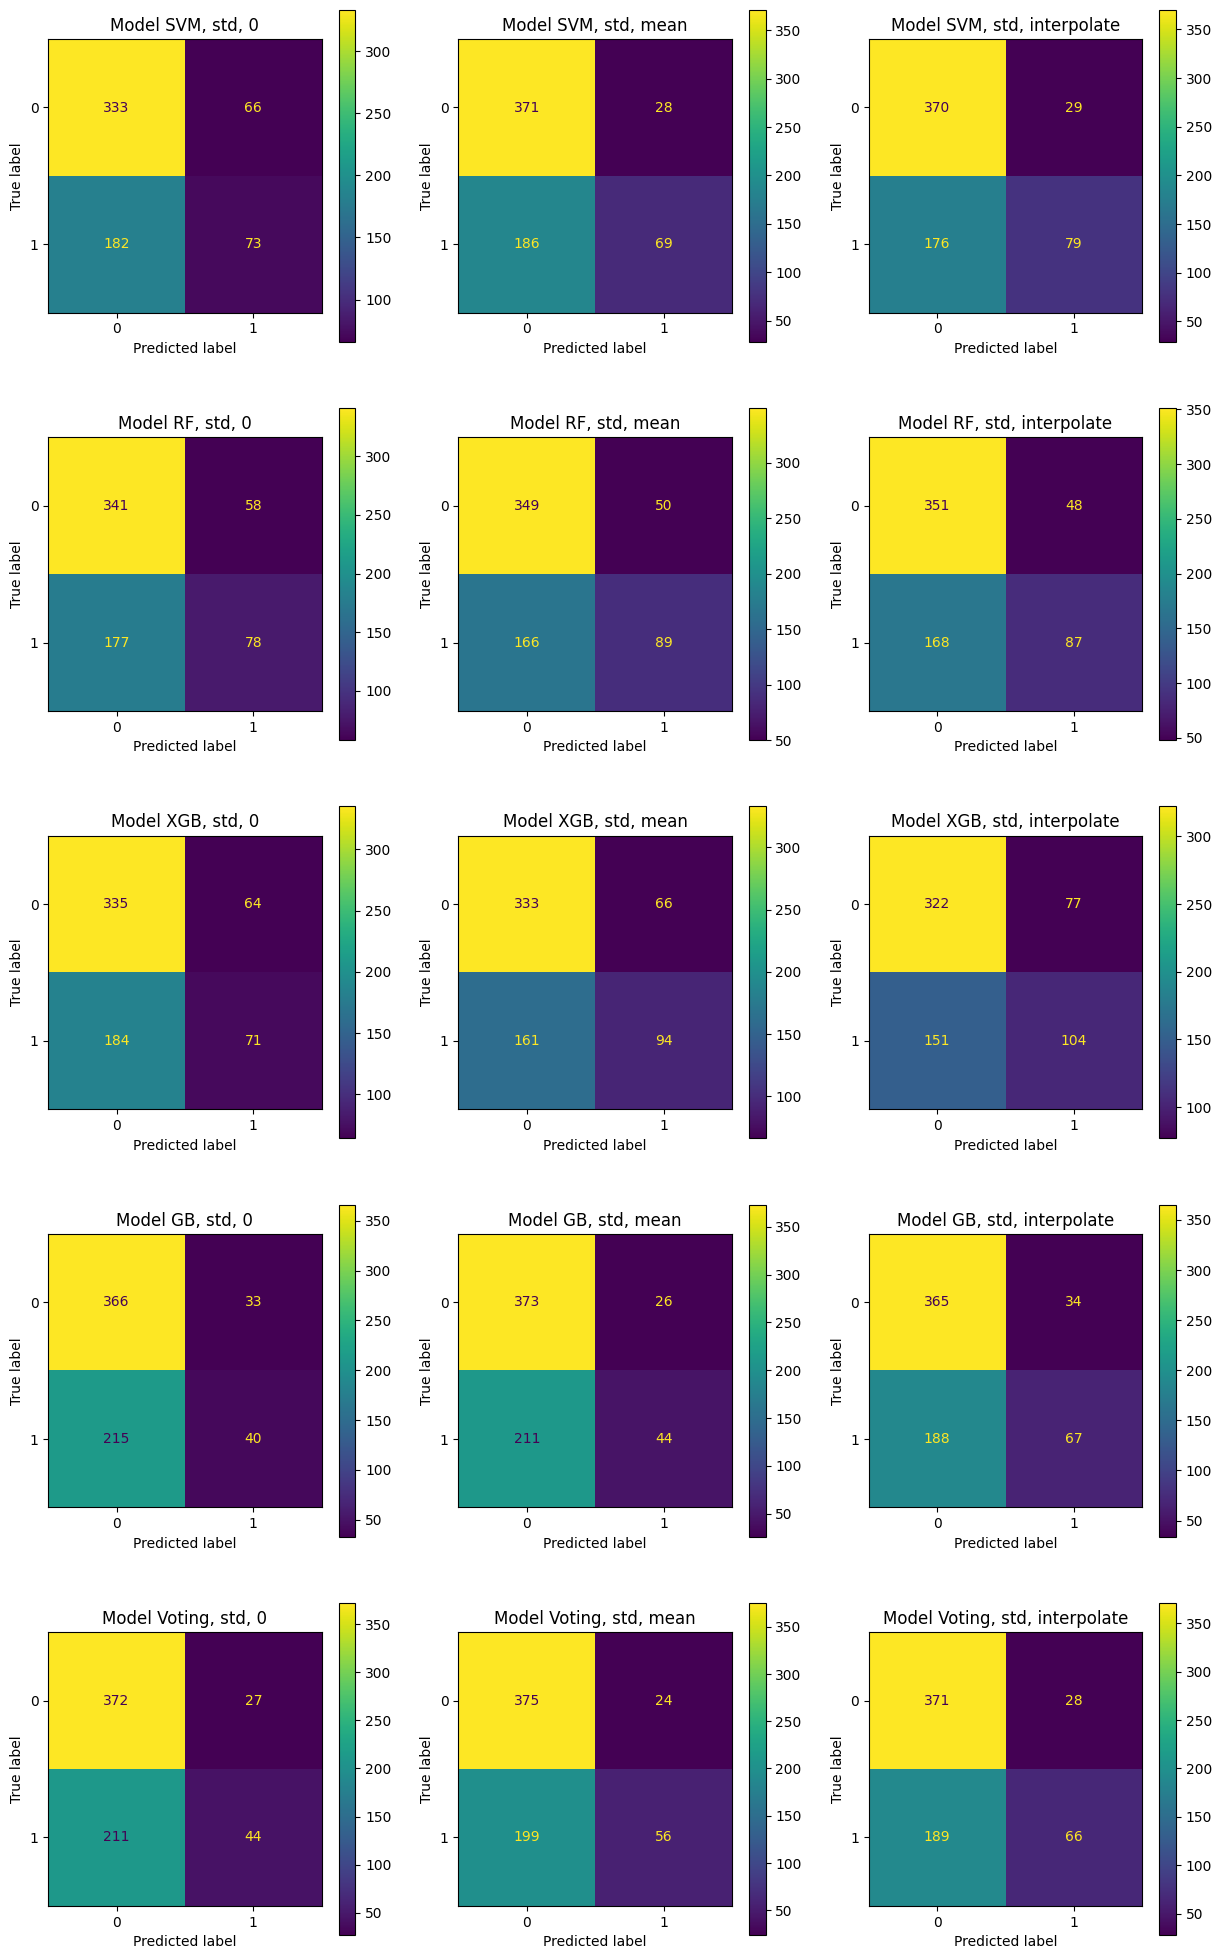

In [133]:
confusion_matrix_list = [modelSVM_std_0.get_confussion_matrix(), modelSVM_std_mean.get_confussion_matrix(), modelSVM_std_interpolate.get_confussion_matrix(),
                         modelRF_std_0.get_confussion_matrix(), modelRF_std_mean.get_confussion_matrix(), modelRF_std_interpolate.get_confussion_matrix(),
                         modelXGB_std_0.get_confussion_matrix(), modelXGB_std_mean.get_confussion_matrix(), modelXGB_std_interpolate.get_confussion_matrix(),
                         modelGB_std_0.get_confussion_matrix(), modelGB_std_mean.get_confussion_matrix(), modelGB_std_interpolate.get_confussion_matrix(),
                         modelVoting_std_0.get_confussion_matrix(), modelVoting_std_mean.get_confussion_matrix(), modelVoting_std_interpolate.get_confussion_matrix()]
confusion_matrix_labels_list = ['Model SVM, std, 0', 'Model SVM, std, mean', 'Model SVM, std, interpolate',
                                'Model RF, std, 0', 'Model RF, std, mean', 'Model RF, std, interpolate',
                                'Model XGB, std, 0', 'Model XGB, std, mean', 'Model XGB, std, interpolate',
                                'Model GB, std, 0', 'Model GB, std, mean', 'Model GB, std, interpolate',
                                'Model Voting, std, 0', 'Model Voting, std, mean', 'Model Voting, std, interpolate']


showConfussionMatrix(confusion_matrix_list, confusion_matrix_labels_list)
